In [1]:
# Third-party
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from scipy.stats import boxcox
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef


import gc
from xgboost import XGBClassifier

In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")
sub_df = pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")

In [3]:
sub_df.head()

,id,class
0,3116945,e
1,3116946,e
2,3116947,e
3,3116948,e
4,3116949,e


In [4]:
train_df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [5]:
test_df.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,...,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,...,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [6]:
print(f"Train shape: {train_df.shape}\nTest shape: {test_df.shape}")

Train shape: (3116945, 22)
Test shape: (2077964, 21)


In [7]:
train_df, test_df = train_df.drop(['id'], axis=1), test_df.drop(['id'], axis=1)

# EDA

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 499.4+ MB


## Categorical features

In [9]:
cat_cols = train_df.select_dtypes(include='object').columns
cat_cols

Index(['class', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color',
       'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object')

In [10]:
# Calculate the percentage of missing values for each categorical column
missing_percentage = train_df[cat_cols].isnull().sum() / train_df.shape[0] * 100
missing_percentage

class                    0.000000
cap-shape                0.001283
cap-surface             21.528227
cap-color                0.000385
does-bruise-or-bleed     0.000257
gill-attachment         16.809280
gill-spacing            40.373988
gill-color               0.001829
stem-root               88.452732
stem-surface            63.551362
stem-color               0.001219
veil-type               94.884350
veil-color              87.936970
has-ring                 0.000770
ring-type                4.134818
spore-print-color       91.425482
habitat                  0.001444
season                   0.000000
dtype: float64

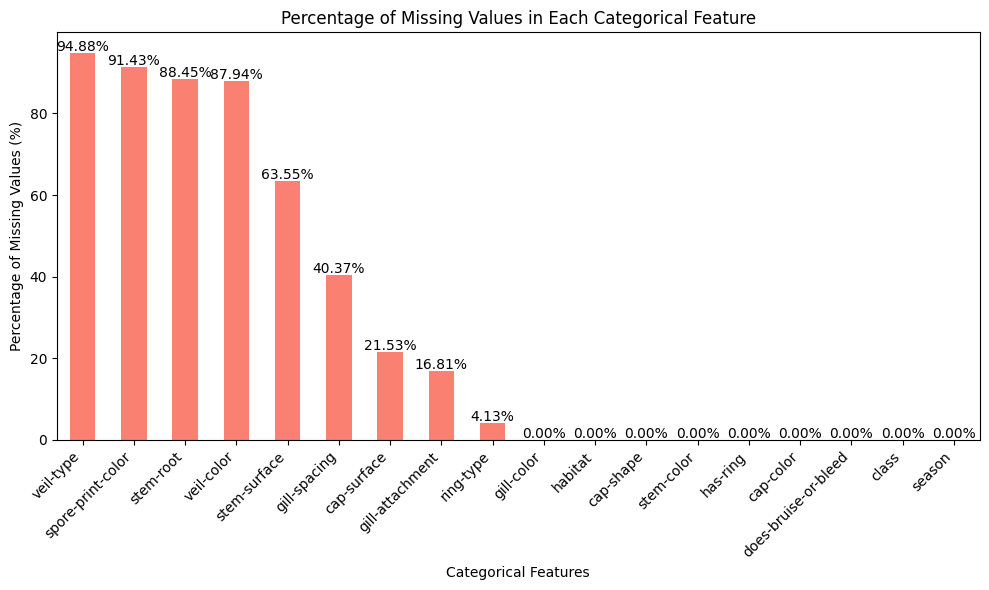

In [11]:
# Plotting the bar plot
plt.figure(figsize=(10, 6))
ax = missing_percentage.sort_values(ascending=False).plot(kind='bar', color='salmon')

# Annotating each bar with the percentage of missing values
for index, value in enumerate(missing_percentage.sort_values(ascending=False)):
    ax.text(index, value + 0.5, f'{value:.2f}%', ha='center', fontsize=10)

plt.title('Percentage of Missing Values in Each Categorical Feature')
plt.xlabel('Categorical Features')
plt.ylabel('Percentage of Missing Values (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(missing_percentage) + 5)  # Adjust ylim for better visualization of text
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

### Drop columns if we miss more than X% of values

In [12]:
# Identify columns with more than X% missing values
columns_to_drop = missing_percentage[missing_percentage > 40].index

# Drop those columns from the DataFrame
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

# Select categorical columns, excluding the 'class' column and columns with more than 40% of missing values
reduced_cat_cols = train_df.select_dtypes(include='object').drop(['class'], axis=1).columns

In [13]:
for col in reduced_cat_cols:
    unique_values = train_df[col].unique()
    print(f'{col}: {unique_values}')

cap-shape: ['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' nan 'w' 'k' 'l' '19.29' '5 f' 't'
 'g' 'z' 'a' '2.85' '7 x' 'r' 'u' '3.55' 'is s' 'y' '4.22' '3.6' '21.56'
 'i' '6 x' '24.16' '8' 'm' 'ring-type' '10.13' 'is p' '7.43' 'h' '0.82'
 '10.46' '2.77' '2.94' '12.62' '5.15' '19.04' '4.97' '49.21' 'b f' '9.13'
 '1.66' '3.37' '7.21' '3.25' '11.12' '3 x' '4.3' '7.41' '6.21' '8.29'
 '54.78' '20.25' '3.52' '3.04' '2.63' '3.91' '6.44' '8.3' '7.6' '17.44'
 '4.33' '2.82' '6.53' '19.06']
cap-surface: ['s' 'h' 'y' 'l' 't' 'e' 'g' nan 'd' 'i' 'w' 'k' '15.94' 'f' 'n' 'r' 'o'
 'a' 'u' 'z' '2.7' 'does l' '5.07' 'p' 'b' 'm' 'cap-diameter' '1.43' 'x'
 '7.14' 'c' 'is h' 'does t' '0.85' '6.57' '12.79' '6.45' '4.66' '23.18'
 '3.06' '16.39' '4.21' 'veil-color' '11.78' '8.1' 'has-ring' 'does h'
 '1.42' 'class' 'has h' 'does None' '10.83' 'season' '8.96' '14.04' '5.73'
 'is None' '24.38' '2.81' '0.88' '2.11' '2.79' 'ring-type'
 'does-bruise-or-bleed' '4.93' 'spore-print-color' 'spore-color' '2.92'
 '2.51' '7.99' 

### Replace values greater than one, not in category and not str with NaN

In [14]:
for col in reduced_cat_cols:
    train_df[col] = train_df[col].apply(lambda x: x if isinstance(x, str) and (len(x) == 1 and x.isalpha()) else np.nan)
    test_df[col] = test_df[col].apply(lambda x: x if isinstance(x, str) and (len(x) == 1 and x.isalpha()) else np.nan)

In [15]:
# Iterate over each column in reduced_cat_cols and print the unique values
for col in reduced_cat_cols:
    unique_values = train_df[col].unique()
    print(f'Column {col} has the following unique values: {unique_values}')

Column cap-shape has the following unique values: ['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' nan 'w' 'k' 'l' 't' 'g' 'z' 'a'
 'r' 'u' 'y' 'i' 'm' 'h']
Column cap-surface has the following unique values: ['s' 'h' 'y' 'l' 't' 'e' 'g' nan 'd' 'i' 'w' 'k' 'f' 'n' 'r' 'o' 'a' 'u'
 'z' 'p' 'b' 'm' 'x' 'c']
Column cap-color has the following unique values: ['u' 'o' 'b' 'g' 'w' 'n' 'e' 'y' 'r' 'p' 'k' 'l' 'i' 'h' 'd' 's' 'a' 'f'
 nan 'c' 'x' 'm' 'z' 't']
Column does-bruise-or-bleed has the following unique values: ['f' 't' 'd' nan 'w' 'o' 'b' 'x' 'p' 'g' 'y' 'r' 'a' 'l' 'i' 'c' 'n' 'z'
 's' 'k' 'h' 'e' 'u']
Column gill-attachment has the following unique values: ['a' 'x' 's' 'd' 'e' nan 'f' 'p' 'l' 'm' 'b' 'n' 'g' 'i' 'u' 't' 'o' 'c'
 'w' 'k' 'r' 'h' 'z' 'y']
Column gill-color has the following unique values: ['w' 'n' 'g' 'k' 'y' 'f' 'p' 'o' 'b' 'u' 'e' 'r' 'd' 't' nan 'z' 'h' 'x'
 's' 'c' 'm' 'l' 'a' 'i']
Column stem-color has the following unique values: ['w' 'o' 'n' 'y' 'e' 'u' 'p' 'f' 'g' 'r

### Fill NaN with mode

In [16]:
# Iterate over each column in reduced_cat_cols
for col in reduced_cat_cols:
    # Calculate the mode for the column
    mode_value = train_df[col].mode()[0]  # mode() returns a Series, [0] gets the most frequent value
    
    # Replace NaN values with the mode
    train_df[col].fillna(mode_value, inplace=True)
    test_df[col].fillna(mode_value, inplace=True)

/tmp/ipykernel_34/4112569232.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(mode_value, inplace=True)
/tmp/ipykernel_34/4112569232.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [17]:
# Iterate over each column in reduced_cat_cols and print the number of unique values
for col in reduced_cat_cols:
    unique_count = train_df[col].nunique()
    print(f'Column {col} has {unique_count} unique values.')

Column cap-shape has 23 unique values.
Column cap-surface has 23 unique values.
Column cap-color has 23 unique values.
Column does-bruise-or-bleed has 22 unique values.
Column gill-attachment has 23 unique values.
Column gill-color has 23 unique values.
Column stem-color has 23 unique values.
Column has-ring has 21 unique values.
Column ring-type has 23 unique values.
Column habitat has 23 unique values.
Column season has 4 unique values.


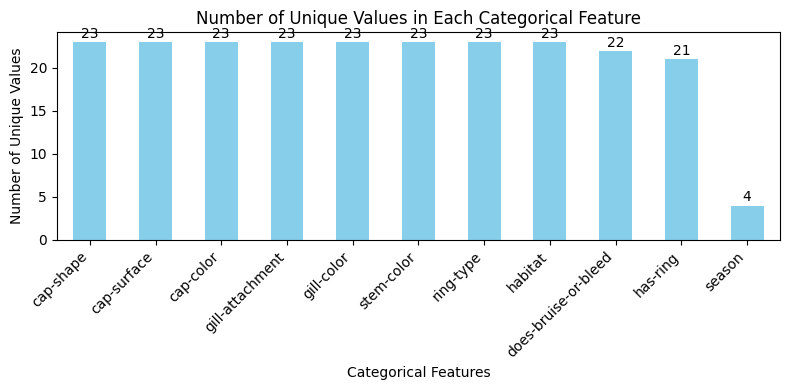

In [18]:
# Calculate the number of unique values for each categorical column
unique_values = {col: train_df[col].nunique() for col in reduced_cat_cols}

# Convert the dictionary to a pandas Series for easy plotting
unique_values_series = pd.Series(unique_values)

# Plotting the bar plot
plt.figure(figsize=(8, 4))
ax = unique_values_series.sort_values(ascending=False).plot(kind='bar', color='skyblue')

# Annotating each bar with the number of unique values
for index, value in enumerate(unique_values_series.sort_values(ascending=False)):
    ax.text(index, value + 0.5, str(value), ha='center', fontsize=10)

plt.title('Number of Unique Values in Each Categorical Feature')
plt.xlabel('Categorical Features')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

## Numerical features

In [19]:
num_cols = train_df.select_dtypes(include='float').columns
num_cols

Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')

In [20]:
# Calculate the percentage of missing values for each numerical column
missing_percentage = train_df[num_cols].isnull().sum() / train_df.shape[0] * 100
missing_percentage

cap-diameter    0.000128
stem-height     0.000000
stem-width      0.000000
dtype: float64

### Fill NaN with mean

In [21]:
col = 'cap-diameter'
# Calculate the mean for the column
mean_value = train_df[col].mean()

# Replace NaN values with the mean in train_df
train_df[col].fillna(mean_value, inplace=True)

# Replace NaN values with the same mean value in test_df
test_df[col].fillna(mean_value, inplace=True)

/tmp/ipykernel_34/17733691.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(mean_value, inplace=True)
/tmp/ipykernel_34/17733691.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [22]:
def visualize_numerical_distributions(df, exclude_columns='id'):
    """
    Visualizes the distribution of numerical features in the DataFrame using histograms and KDE plots,
    excluding specified columns.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numerical features to visualize.
    - exclude_columns (list): List of column names to exclude from visualization.
    
    Returns:
    - None: Displays the plots.
    """
    # Ensure exclude_columns is a list
    if exclude_columns is None:
        exclude_columns = []

    # Identify numerical columns and exclude specified ones
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    fig.suptitle('Distribution of Numerical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical column and create a histogram with KDE
    for i, col in enumerate(numerical_columns):
        sns.histplot(df[col], kde=True, ax=axes[i], color="skyblue", element="step", stat="density")
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Density', fontsize=12)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


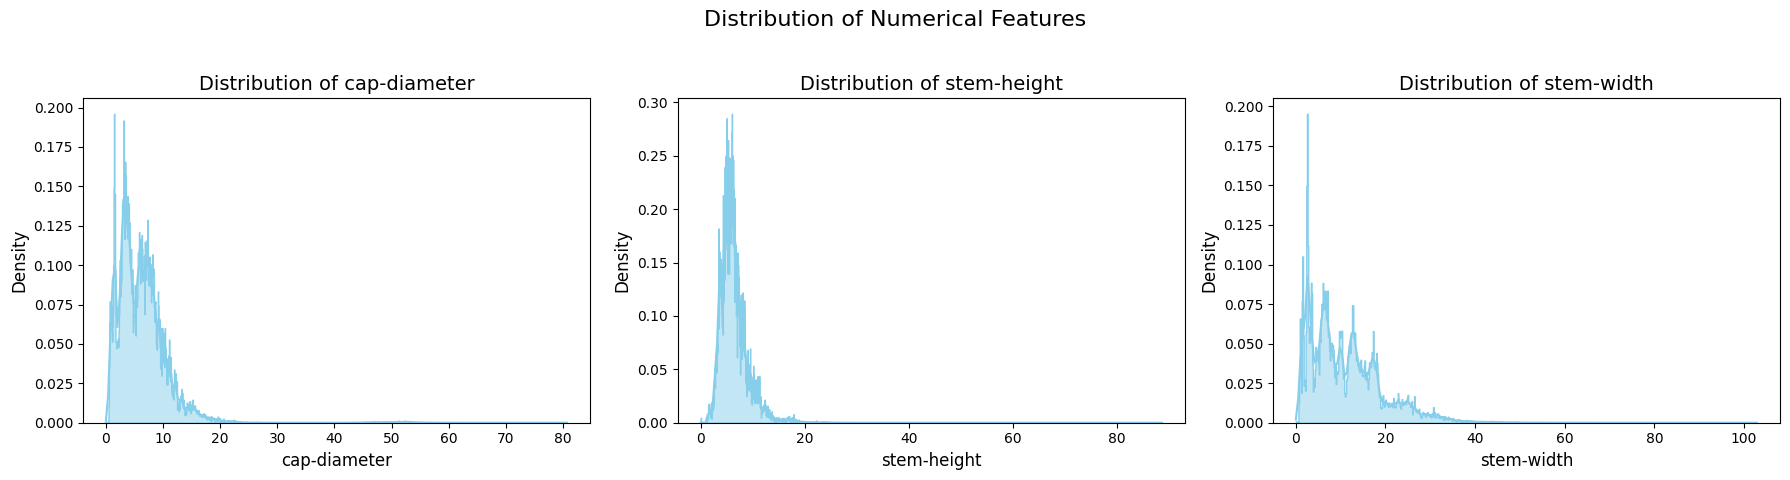

In [23]:
visualize_numerical_distributions(train_df)

In [24]:
def handle_skewness(df, threshold=2.0):
    """
    Applies Box-Cox transformation to numerical columns in the DataFrame where skewness exceeds a threshold.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - threshold (float): Skewness threshold to decide which columns to transform.
    
    Returns:
    - pd.DataFrame: DataFrame with transformed columns.
    - dict: Dictionary of lambda values used for Box-Cox transformation for each column.
    """
    numeric_cols = df.select_dtypes(include=['number']).columns
    lambda_dict = {}
    
    for col in numeric_cols:
        skewness = df[col].skew()
        # Check the skewness and ensure positive values for Box-Cox
        if skewness > threshold:
            # Adding 1 to shift all data to positive if there are zero or negative values
            df[col] = df[col] + 1
            df[col], fitted_lambda = boxcox(df[col])
            lambda_dict[col] = fitted_lambda
    
    return df, lambda_dict

# Example usage:
# df is your DataFrame containing the numerical data
train_df, lambda_values = handle_skewness(train_df)
test_df, lambda_test = handle_skewness(test_df)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


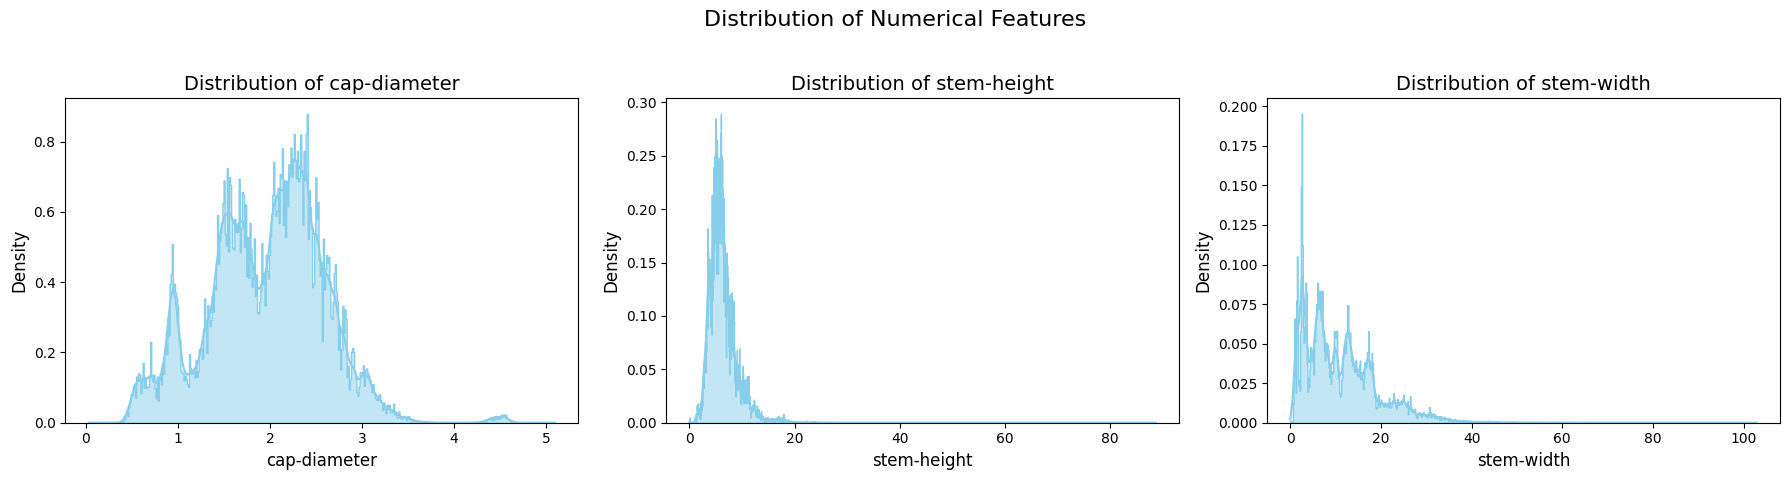

In [25]:
visualize_numerical_distributions(train_df)

In [26]:
def calculate_outliers_percentage(df):
    """
    Calculates the percentage of data considered outliers based on the IQR method for each numerical column.

    Parameters:
    - df (pd.DataFrame): DataFrame to analyze.

    Returns:
    - None: Prints the percentage of outliers for each numerical column.
    """
    outlier_counts = {}
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)

    # Print the percentage of outliers for each column
    for column in outlier_counts:
        percentage = (outlier_counts[column] / len(df)) * 100
        print(f"Percentage of outliers in {column}: {percentage:.2f}%")


calculate_outliers_percentage(train_df)

Percentage of outliers in cap-diameter: 0.43%
Percentage of outliers in stem-height: 4.25%
Percentage of outliers in stem-width: 2.13%


In [27]:
def handle_outliers(df):
    """
    Handles outliers in a DataFrame by capping based on the IQR method.

    Parameters:
    - df (pd.DataFrame): DataFrame to process.

    Returns:
    - pd.DataFrame: DataFrame with outliers handled.
    """
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Capping
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
    return df

# Apply to both training and test datasets
train_df = handle_outliers(train_df)
test_df = handle_outliers(test_df)

### Scale numerical features

In [28]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])

# Transform the test data using the same scaler.
# Directly apply the previously learned parameters (from the training data) to the test data. So no fit.
test_df[num_cols] = scaler.transform(test_df[num_cols])

## Encode categorical columns

In [29]:
# Initialize the OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Apply the encoder to the categorical columns
train_df[reduced_cat_cols] = encoder.fit_transform(train_df[reduced_cat_cols].astype(str))

# Apply the same encoder to our test data columns
test_df[reduced_cat_cols] = encoder.transform(test_df[reduced_cat_cols].astype(str))

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 15 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             float64
 3   cap-surface           float64
 4   cap-color             float64
 5   does-bruise-or-bleed  float64
 6   gill-attachment       float64
 7   gill-color            float64
 8   stem-height           float64
 9   stem-width            float64
 10  stem-color            float64
 11  has-ring              float64
 12  ring-type             float64
 13  habitat               float64
 14  season                float64
dtypes: float64(14), object(1)
memory usage: 356.7+ MB


# Prepare for training

In [31]:
y = train_df['class'] # Target

# Encoding the label
le = LabelEncoder()
train_df['class'] = y = le.fit_transform(train_df['class'])

In [32]:
# Prepare features
X = train_df.drop(['class'], axis=1)  # Features

In [33]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    shuffle=True, stratify=train_df['class'])

In [34]:
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [35]:
# Define the parameters for the XGBoost classifier
xgb_optuna_params = {
    'n_estimators': 6000,
    'alpha': 0.0002,
    'subsample': 0.60,
    'colsample_bytree': 0.4,
    'max_depth': 13, 
    'min_child_weight': 10,
    'learning_rate': 0.002,
    'gamma': 5.6e-08,
    # 'early_stopping_rounds': 500,
    'device': "cuda",
    'objective': 'binary:logistic',
    'tree_method': "hist"
}

# Initialize the XGBClassifier with the specified parameters
xgbclf = XGBClassifier(**xgb_optuna_params)

# Fit the model on the training data
xgbclf.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)],
    verbose=200,
    eval_metric=mcc_metric,
)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68777	validation_0-mcc:0.00000
[200]	validation_0-logloss:0.50094	validation_0-mcc:0.95496
[400]	validation_0-logloss:0.38013	validation_0-mcc:0.96866
[600]	validation_0-logloss:0.29871	validation_0-mcc:0.97113
[800]	validation_0-logloss:0.23931	validation_0-mcc:0.97218
[1000]	validation_0-logloss:0.19664	validation_0-mcc:0.97284
[1200]	validation_0-logloss:0.16413	validation_0-mcc:0.97347
[1400]	validation_0-logloss:0.13889	validation_0-mcc:0.97394
[1600]	validation_0-logloss:0.11994	validation_0-mcc:0.97426
[1800]	validation_0-logloss:0.10562	validation_0-mcc:0.97457
[2000]	validation_0-logloss:0.09412	validation_0-mcc:0.97489
[2200]	validation_0-logloss:0.08488	validation_0-mcc:0.97521
[2400]	validation_0-logloss:0.07761	validation_0-mcc:0.97541
[2600]	validation_0-logloss:0.07185	validation_0-mcc:0.97557
[2800]	validation_0-logloss:0.06738	validation_0-mcc:0.97573
[3000]	validation_0-logloss:0.06363	validation_0-mcc:0.97593
[3200]	validation_0-logloss:0.0

XGBClassifier(alpha=0.0002, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5.6e-08, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.002, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=6000, n_jobs=None,
              num_parallel_tree=None, ...)

In [36]:
test_pred = xgbclf.predict(test_df)
test_pred

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:46:33] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


array([0, 1, 1, ..., 1, 0, 0])

In [37]:
test_pred_labels = le.inverse_transform(test_pred)
test_pred_labels

array(['e', 'p', 'p', ..., 'p', 'e', 'e'], dtype=object)

In [38]:
sub_df['class'] = test_pred_labels
sub_df.to_csv('submission.csv', index=False)